In [42]:
import sys
import os

sys.path.append(os.path.abspath("/home/miguelmd/projects/big-data-bowl-2026-analytics"))

from src.io.datasets import CSVReader
from src.core.settings import get_settings

import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt

settings = get_settings()

In [43]:
players = CSVReader().read(settings.PLAYERS_FILE)
scores = CSVReader().read(settings.SCORES_FILE)
plays = CSVReader().read(settings.CLEANED_PLAYS_FILE)
inferences = CSVReader().read(settings.INFERENCE_RESULTS_FILE)

2025-12-12 01:01:15.328 | DEBUG    | src.io.datasets:read:23 - Reading data from /home/miguelmd/projects/big-data-bowl-2026-analytics/data/cleaned/players.csv
2025-12-12 01:01:15.334 | DEBUG    | src.io.datasets:read:23 - Reading data from /home/miguelmd/projects/big-data-bowl-2026-analytics/data/scores.csv
2025-12-12 01:01:15.340 | DEBUG    | src.io.datasets:read:23 - Reading data from /home/miguelmd/projects/big-data-bowl-2026-analytics/data/cleaned/plays.csv
2025-12-12 01:01:15.357 | DEBUG    | src.io.datasets:read:23 - Reading data from /home/miguelmd/projects/big-data-bowl-2026-analytics/data/processed/inference/results.csv


In [44]:
MIN_NUM_PLAYS = 10
valid_defenders = scores.groupby("defender_id").filter(lambda x: len(x) >= MIN_NUM_PLAYS)

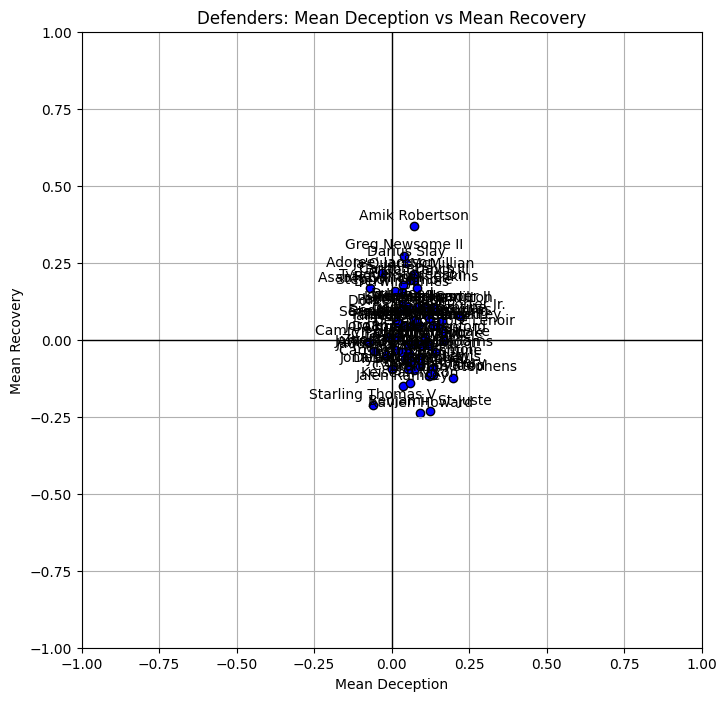

In [45]:

# Step 1: Calculate mean deception and recovery for each defender
mean_deception_by_defender = valid_defenders.groupby("defender_id")[
    "deception_score"
].mean()
mean_recovery_by_defender = valid_defenders.groupby("defender_id")[
    "recovery_score"
].mean()

defenders_df = pd.DataFrame(
    {
        "defender_id": mean_deception_by_defender.index,
        "mean_deception": mean_deception_by_defender.values,
        "mean_recovery": mean_recovery_by_defender.values,
    }
)

# Merge with player details for names
defenders_df = defenders_df.merge(
    players[["nfl_id", "player_name", "player_position"]],
    left_on="defender_id",
    right_on="nfl_id",
    how="left",
)
defenders_df.drop(columns=["nfl_id"], inplace=True)

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot for Mean Deception vs Mean Recovery
ax.scatter(
    defenders_df["mean_deception"],
    defenders_df["mean_recovery"],
    c="blue",
    edgecolor="black",
)

# Annotate the players with their names
for i, player in enumerate(defenders_df["player_name"]):
    ax.annotate(
        player,
        (
            defenders_df["mean_deception"].iloc[i],
            defenders_df["mean_recovery"].iloc[i],
        ),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )

# Set labels and title
ax.set_xlabel("Mean Deception")
ax.set_ylabel("Mean Recovery")
ax.set_title("Defenders: Mean Deception vs Mean Recovery")

# Draw horizontal and vertical lines at 0 (quadrants)
ax.axhline(0, color="black", linewidth=1)
ax.axvline(0, color="black", linewidth=1)

# Set axis limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Show grid
ax.grid(True)

# Show the plot
plt.show()

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Assuming valid_defenders and players DataFrames are already loaded
# and defenders_df has been created (including 'mean_deception', 'mean_recovery', 'player_name', etc.)

# --- Define the new Style Palette ---
background_color = "#1D384B"  # Dark Gray for background
grid_color = "#9693A4"        # Light Gray for grid/text
line_color = "#AB1951"        # Team Red (Bold color for annotations)
highlight_color = "#B21952"   # Slightly different red for the main points
muted_color = "#4D6377"       # Muted color for the bulk of the points
text_color = "white"          # White for titles and core labels

# --- Re-running annotation logic (using mean as per the code provided) ---

# Calculate a metric for how "extreme" the player is (distance from center, 0,0)
defenders_df['distance_from_center'] = (
    defenders_df['mean_deception']**2 + defenders_df['mean_recovery']**2
)**0.5

# Define the number of top players to annotate per quadrant
N_annotate = 5

# Define the four quadrants
Q1 = defenders_df[
    (defenders_df['mean_deception'] > 0) & (defenders_df['mean_recovery'] > 0)
].nlargest(N_annotate, 'distance_from_center')

Q2 = defenders_df[
    (defenders_df['mean_deception'] < 0) & (defenders_df['mean_recovery'] > 0)
].nlargest(N_annotate, 'distance_from_center')

Q3 = defenders_df[
    (defenders_df['mean_deception'] < 0) & (defenders_df['mean_recovery'] < 0)
].nlargest(N_annotate, 'distance_from_center')

Q4 = defenders_df[
    (defenders_df['mean_deception'] > 0) & (defenders_df['mean_recovery'] < 0)
].nlargest(N_annotate, 'distance_from_center')

# Combine all extreme players
top_players_to_annotate = pd.concat([Q1, Q2, Q3, Q4]).drop_duplicates()


# --- Step 3: Plot the Styled Data ---

fig, ax = plt.subplots(figsize=(10, 10))

# Apply Dark Background Color
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# 1. Plot all points (muted)
ax.scatter(
    defenders_df["mean_deception"],
    defenders_df["mean_recovery"],
    c=muted_color,  # Use the dark mode muted color
    s=20,           # Smaller size
    alpha=0.6,
    label="All Defenders",
)

# 2. Plot the highlighted extreme players
ax.scatter(
    top_players_to_annotate["mean_deception"],
    top_players_to_annotate["mean_recovery"],
    c=highlight_color, # Use the bold highlight color
    s=70,              # Slightly larger for emphasis
    edgecolor="white", # White edge to make it pop on dark background
    zorder=5,
    label=f"Top {N_annotate} Performers (by Quadrant)",
)

# 3. Annotate only the highlighted players
for index, row in top_players_to_annotate.iterrows():
    x = row["mean_deception"]
    y = row["mean_recovery"]
    name = row["player_name"]

    # Logic for placing the label based on the quadrant
    if x >= 0 and y >= 0: # Q1 (Top Right)
        offset = (5, 5); ha = 'left'
    elif x < 0 and y >= 0: # Q2 (Top Left)
        offset = (-5, 5); ha = 'right'
    elif x < 0 and y < 0: # Q3 (Bottom Left)
        offset = (-5, -5); ha = 'right'
    else: # Q4 (Bottom Right)
        offset = (5, -5); ha = 'left'

    ax.annotate(
        name,
        (x, y),
        textcoords="offset points",
        xytext=offset,
        ha=ha,
        fontsize=9,
        color="white", # Use grid color for subtle text
        fontweight='bold'
    )

# 4. Set labels and title
ax.set_xlabel("Mean Deception Score", color=text_color, fontsize=12, labelpad=10)
ax.set_ylabel("Mean Recovery Score", color=text_color, fontsize=12, labelpad=10)
# ax.set_title("Defenders: Deception vs Recovery - Quadrant Analysis", color=text_color, fontsize=18, pad=15)

# 5. Draw horizontal and vertical lines at 0 (quadrants)
ax.axhline(0, color=text_color, linestyle='-', linewidth=1.5, alpha=0.8) # Solid white lines
ax.axvline(0, color=text_color, linestyle='-', linewidth=1.5, alpha=0.8) # Solid white lines

# Apply the axis styling (ticks and spines)
ax.tick_params(axis='x', labelcolor=grid_color, labelsize=10)
ax.tick_params(axis='y', labelcolor=grid_color, labelsize=10)

# Remove the surrounding box/spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(grid_color)
ax.spines['bottom'].set_color(grid_color)


# Add Quadrant Labels for context
ax.text(0.97, 0.97, 'Q1', transform=ax.transAxes, ha='right', va='top', fontsize=11, color=line_color, weight='bold')
ax.text(0.03, 0.97, 'Q2', transform=ax.transAxes, ha='left', va='top', fontsize=11, color=line_color, weight='bold')
ax.text(0.03, 0.03, 'Q3', transform=ax.transAxes, ha='left', va='bottom', fontsize=11, color=line_color, weight='bold')
ax.text(0.97, 0.03, 'Q4', transform=ax.transAxes, ha='right', va='bottom', fontsize=11, color=line_color, weight='bold')


# 6. Set the NEW axis limits (The "zoom")
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.4, 0.4)

# Show grid
ax.grid(True, linestyle=':', color=grid_color, alpha=0.4, zorder=0)

# Show legend (placed outside to save space)
# ax.legend(
#     loc='upper left',
#     bbox_to_anchor=(1.05, 1),
#     facecolor=background_color,
#     edgecolor=grid_color,
#     labelcolor=text_color
# )

# Show the plot
# plt.show()
fig.savefig("../assets/figures/quadrant.png", facecolor=ax.get_facecolor(), dpi=200, bbox_inches='tight')
plt.close(fig)